# Objective

The objective of this project is to familiarize ourselves with working with a data cube in the field of integral field spectroscopy (IFU). We will answer the proposed exercises. Below, we discuss the main objectives of the project. We will extract information from the cube and work correctly with the three dimensions of the cube, taking into account the units used and the necessary conversion factors. We will represent different types of IFU images, such as a 'white' image (moment 0), an r-band image, an i-band image, and an r-i color image. Finally, we will work with the spectra of some points in the image to identify the lines and, based on the emission line $H\alpha$, we will calculate the galaxy's redshift (at different points) in order to compare it with the NED catalog redshift.

# Libraries

We start by importing the Python libraries needed to work with the images; [glob](https://docs.python.org/3/library/glob.html) is used to search for files in a directory, [numpy](https://numpy.org/doc/2.2/user/index.html#user) allows performing numerical calculations, [matplotlib](https://matplotlib.org/stable/users/index.html) is used to [plot graphs](https://matplotlib.org/stable/gallery/), [astropy](https://docs.astropy.org/en/stable/index_user_docs.html) has different modules to work with astronomical images and [photutils](https://photutils.readthedocs.io/en/stable/user_guide/index.html) allows the detection and analysis of sources in astronomical images.

In [1]:
import glob
from astropy.io import fits

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from astropy.wcs import WCS
from astropy.modeling import models, fitting



from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, aperture_photometry

# Functions

Next, we define the function transform_ticks. This function will allow us, in the following sections, to convert the axes of the represented images. By using this function, we will center the image and convert to arcsec units. In short, this function allows us to change the X and Y axes from pixels to $\Delta$X and $\Delta$Y in arcsec, where $\Delta$ is the distance to the galaxy center.

We implement it through a function since the conversion is required in several sections, and therefore, it will be used repeatedly.

In [2]:
def transform_ticks(image, centerX_real, centerY_real):
    """
    Translate the coordinates of the image center and generate the ticks for the axes in astronomical coordinates.

    Parameters:
    - image: Image to display (to get axis size).
    - centerX_real, centerY_real: Coordinates in pixels of the image center.
    
    Returns:
        - centerX, centerY: Transformed coordinates of the center.
        - xticks, yticks: Ticks in pixels.
        - ticksRAlabel, ticksDEClabel: Ticks with the converted units.
    """

    centerX = cd11 * (centerX_real - crpix1) + crval1
    centerY = cd22 * (centerY_real - crpix2) + crval2

    # This is necessary to include 0 in the new ticks.
    x_img = ((0 + centerX) - crval1) / cd11 + crpix1
    y_img = ((0 + centerY) - crval2) / cd22 + crpix2

    
    xticks = np.arange(0, image.shape[1], image.shape[1] // 10)
    yticks = np.arange(0, image.shape[0], image.shape[0] // 10)
    xticks = np.append(xticks, x_img)
    yticks = np.append(yticks, y_img)
    
    ticksRA = cd11 * (xticks - crpix1) + crval1
    ticksDEC = cd22 * (yticks - crpix2) + crval2

    ticksRAlabel = np.round(ticksRA - centerX, 3)
    ticksDEClabel = np.round(ticksDEC - centerY, 3)

    return centerX, centerY, x_img, y_img, xticks, yticks, ticksRAlabel, ticksDEClabel

#  1.- Data Extraction

We start by reading the data cube information. To do this, we store the cube and display its information so that we can work with it.

In [3]:
cube = fits.open('ESO113-G032.fits')
cube.info()

Filename: ESO113-G032.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1532   ()      
  1  DATA          1 CompImageHDU     75   (408, 327, 3681)   float32   
  2  STAT          1 CompImageHDU     47   (408, 327, 3681)   float32   


# 2.- Header reading - extracting information

We proceed to obtain the information from the data cube. To do this, we display the header and focus on the parameters that interest us.

In [4]:
header = cube[1].header
print(repr(header))

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  408 / length of data axis 1                          
NAXIS2  =                  327 / length of data axis 2                          
NAXIS3  =                 3681 / length of data axis 3                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
ZBLANK  =          -2147483647 / null value in the compressed integer array     
EXTNAME = 'DATA    '           / This extension contains data values            
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'  

We collect information on the number of dimensions, the dimensions themselves, and the pixel scale and wavelength step information.

The transformation matrix allows the conversion between pixels and real physical magnitudes, meaning it enables the transition from pixels to DEC (degrees), RA (degrees), and wavelength (angstroms). As specified below, this information is contained in CD1_1, CD2_2, and CD3_3, respectively.

In [5]:
dimensions = [header['NAXIS1'], header['NAXIS2'], header['NAXIS3']]
n_dimensions = len(dimensions)


cd11 = header['CD1_1'] # Pixel scale (X)
cd22 = header['CD2_2'] # Pixel scale (Y)
cd33 = header['CD3_3'] # Wavelength step

In [6]:
crpix1 =  header['CRPIX1']
crpix2 =  header['CRPIX2']
crpix3 =  header['CRPIX3']

crval1 = header['CRVAL1']
crval2 = header['CRVAL2']
crval3 = header['CRVAL3']

Next, the data from the data cube is stored in the variable "data", so it can be used in the following sections.

In [7]:
data = cube[1].data

# 3.- Comparing dimensions

As required by the practice instructions, we compare the dimension values extracted from the FITS header with the dimensions and lengths of the data cube.

Reading the dimensions from the header, we have the following order: RA, DEC, and wavelength. However, when obtaining the dimensions from the data cube using .shape to view the object's dimensions in Python, the order is wavelength, DEC, and RA.

In [33]:
print(dimensions)
data.shape

[408, 327, 3681]


(3681, 327, 408)

# 4.- Galaxy at different wavelengths

In this section, we will display images for different wavelength values, indicating the wavelength in angstroms that we are using, by utilizing the transformation matrix. For this, we will use the coefficients stored in the parameters cd11, cd22, and cd33.

As a result, the images we obtain will have a fixed wavelength value. What we will represent, then, is a matrix with dimensions of DEC and RA.

In [34]:
image1 = data[100, :, :] 
print(f"This is the dimension of the matrix", image1.shape)

lambda1 = cd33 * (100 - crpix3) + crval3
print(f"This is the fixed wavelength we have set: {lambda1} Å")

This is the dimension of the matrix (327, 408)
This is the fixed wavelength we have set: 4873.560546875 Å


Next, we visualize the obtained image. From now on, the representation will be based on the image statistics (or the center of the image). The median, subtracted or added to the standard deviation multiplied by a factor, will be used to adjust vmin and vmax, which help us visualize it.

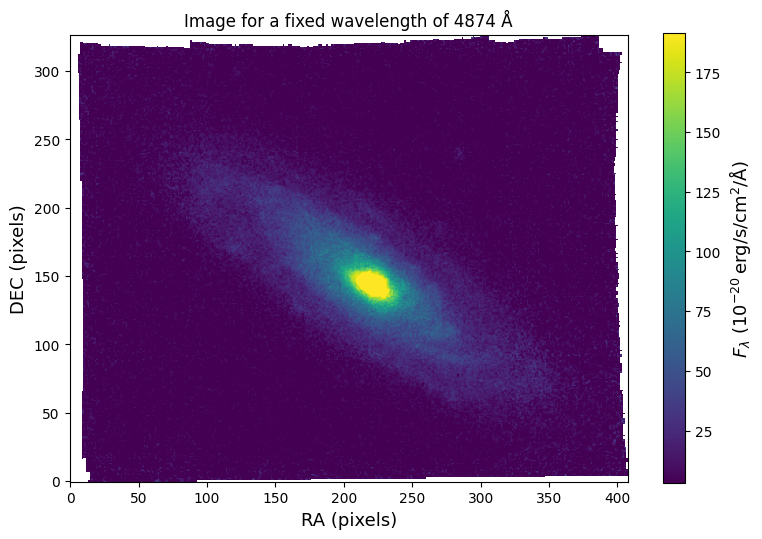

In [35]:
factor1 = 0.0001
factor2 = 8
plt.figure("Image 4_1", figsize=(9, 9))

plt.imshow(
    image1,
    vmin=np.nanmedian(image1) - factor1 * np.nanstd(image1),
    vmax=np.nanmedian(image1) + factor2 * np.nanstd(image1), 
    origin="lower"
)

plt.title(f"Image for a fixed wavelength of {round(lambda1)} Å") 
plt.ylabel("DEC (pixels)", fontsize=13)
plt.xlabel("RA (pixels)", fontsize=13)

cbar = plt.colorbar(label=r"$F_{\lambda}$ ($10^{-20} \, \text{erg/s/cm}^2/\text{Å}$)", shrink=0.65)
cbar.set_label(r"$F_{\lambda}$ ($10^{-20} \, \text{erg/s/cm}^2/\text{Å}$)", fontsize=13)

plt.show()

We obtain another image for another wavelength.

In [36]:
image2 = data[1500, :, :] 
print(f"This is the dimension of the matrix", image2.shape)

lambda2 = cd33 * (1500 - crpix3) + crval3
print(f"This is the fixed wavelength we have set: {lambda2} Å")

This is the dimension of the matrix (327, 408)
This is the fixed wavelength we have set: 6623.560546875 Å


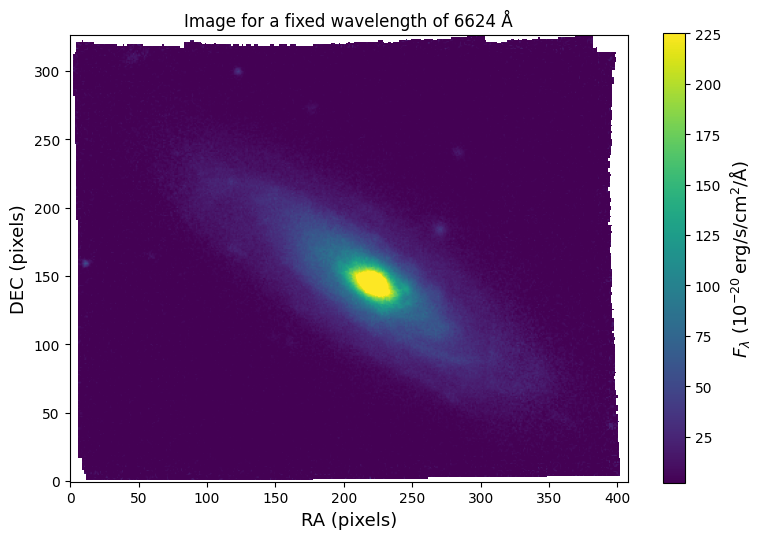

In [37]:
factor1 = 0.0001
factor2 = 8

plt.figure("Image 4_2", figsize=(9, 9))

plt.imshow(
    image2,
    vmin=np.nanmedian(image2) - factor1 * np.nanstd(image2),
    vmax=np.nanmedian(image2) + factor2 * np.nanstd(image2),
    origin="lower"
)

plt.title(f"Image for a fixed wavelength of {round(lambda2)} Å") 
plt.ylabel("DEC (pixels)", fontsize=13)
plt.xlabel("RA (pixels)", fontsize=13)

cbar = plt.colorbar(label=r"$F_{\lambda}$ ($10^{-20} \, \text{erg/s/cm}^2/\text{Å}$)", shrink=0.65)
cbar.set_label(r"$F_{\lambda}$ ($10^{-20} \, \text{erg/s/cm}^2/\text{Å}$)", fontsize=13)

plt.show()

We obtain the last image for another wavelength.

In [38]:
image3 = data[3500, :, :]
print(f"This is the dimension of the matrix", image3.shape)

lambda3=cd33*(3500 - crpix3) + crval3
print(f"This is the fixed wavelength we have set: {lambda3} Å")

This is the dimension of the matrix (327, 408)
This is the fixed wavelength we have set: 9123.560546875 Å


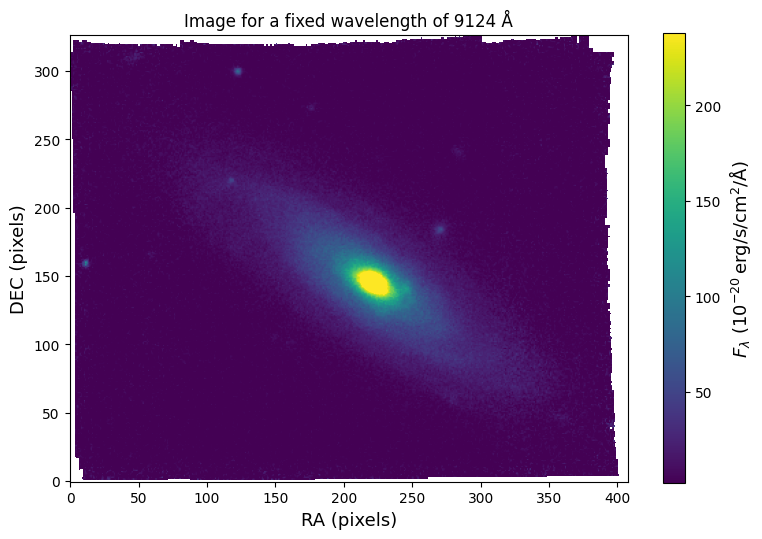

In [39]:
factor1 = 0.0001
factor2 = 10

plt.figure("Image 4_3", figsize=(9, 9))

plt.imshow(
    image3,
    vmin=np.nanmedian(image3) - factor1 * np.nanstd(image3),
    vmax=np.nanmedian(image3) + factor2 * np.nanstd(image1),
    origin="lower"
)

plt.title(f"Image for a fixed wavelength of {round(lambda3)} Å") 
plt.ylabel("DEC (pixels)", fontsize=13)
plt.xlabel("RA (pixels)", fontsize=13)

cbar = plt.colorbar(label=r"$F_{\lambda}$ ($10^{-20} \, \text{erg/s/cm}^2/\text{Å}$)", shrink=0.65)
cbar.set_label(r"$F_{\lambda}$ ($10^{-20} \, \text{erg/s/cm}^2/\text{Å}$)", fontsize=13)

plt.show()

# 5.- Spectra of different pixels

Now we are going to do the opposite: we will fix pixels in the cube and represent the spectrum. To create the representation, we convert all the wavelengths in the cube to Angstrom units using the previously applied relationship. We only need to obtain the wavelengths once, as they will remain the same regardless of the spectrum we represent.

In [77]:
image5_1 = data[:, 50, 50]

lambdasA = [cd33 * (i - crpix3) + crval3 for i in range(3681)]

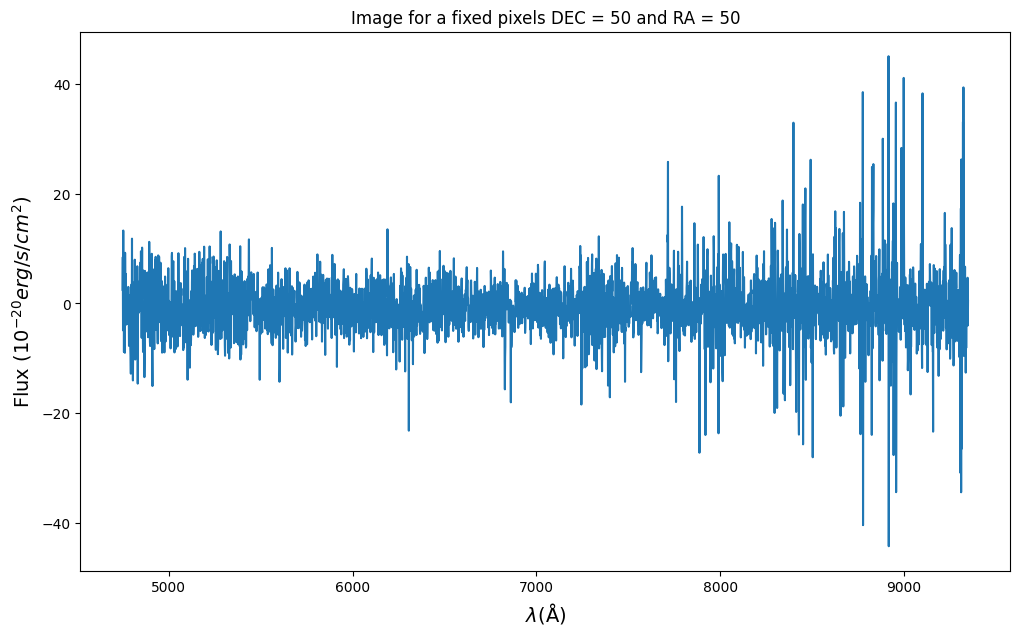

In [41]:
plt.figure("Image 5_1", figsize=(12,7))

plt.plot(lambdasA, image5_1)

plt.title(f"Image for a fixed pixels DEC = 50 and RA = 50") 
plt.ylabel("Flux ($10^{-20}erg/s/cm^2$)", fontsize=14)
plt.xlabel("$\lambda (\mathrm{\AA})$", fontsize=14)

plt.show()

In [42]:
image5_2 = data[:, 225, 150]

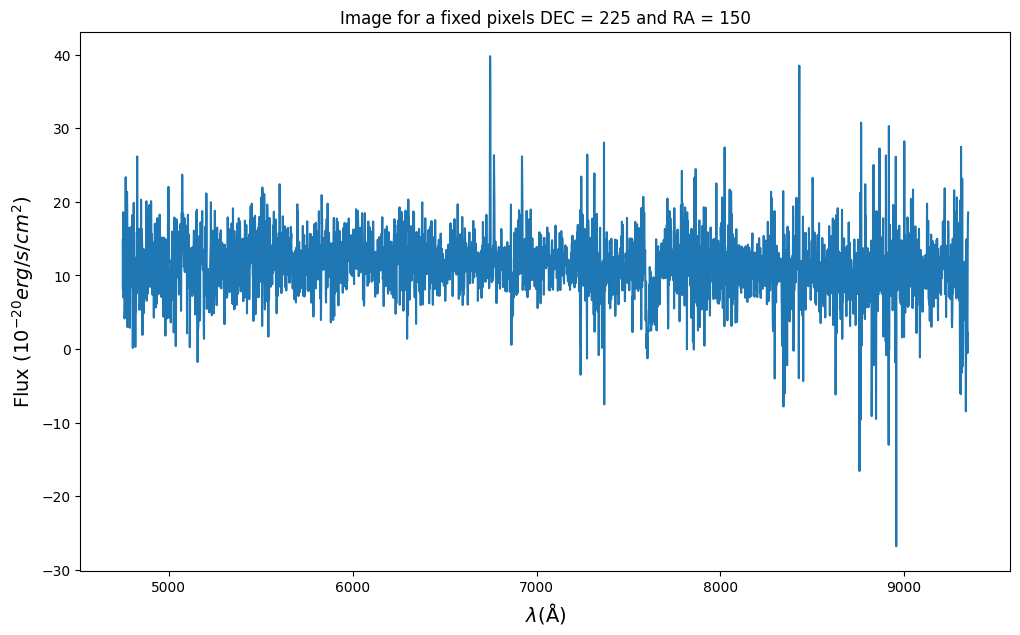

In [43]:
plt.figure("Image 5_2", figsize=(12,7))

plt.plot(lambdasA, image5_2)

plt.title(f"Image for a fixed pixels DEC = 225 and RA = 150") 
plt.ylabel("Flux ($10^{-20}erg/s/cm^2$)", fontsize=14)
plt.xlabel("$\lambda (\mathrm{\AA})$", fontsize=14)

plt.show()

In [44]:
image5_3 = data[:, 260, 120]

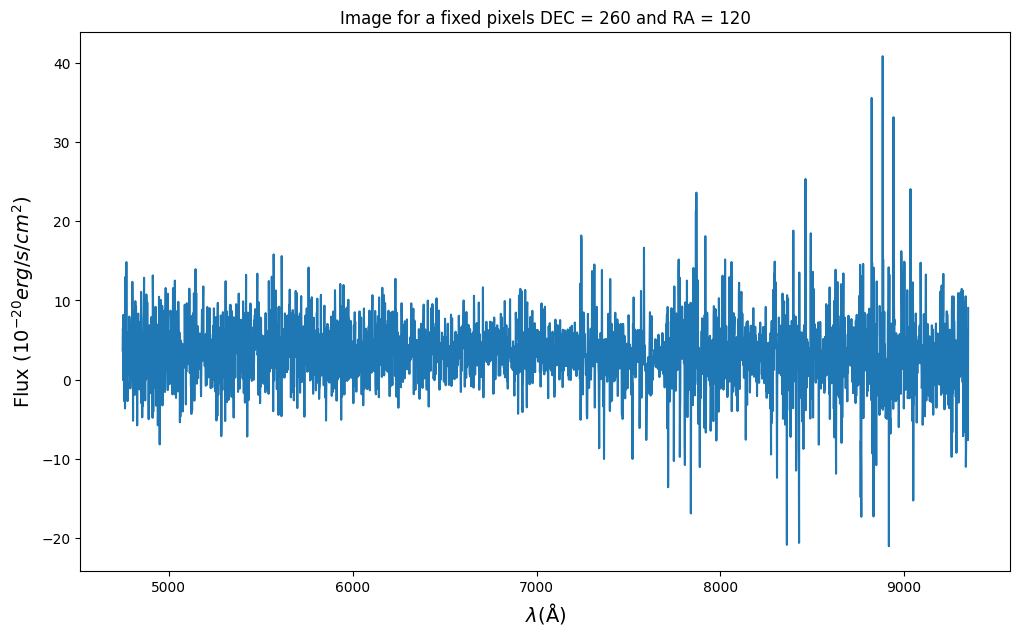

In [45]:
plt.figure("Image 5_3", figsize=(12,7))

plt.plot(lambdasA, image5_3)

plt.title(f"Image for a fixed pixels DEC = 260 and RA = 120") 
plt.ylabel("Flux ($10^{-20}erg/s/cm^2$)", fontsize=14)
plt.xlabel("$\lambda (\mathrm{\AA})$", fontsize=14)

plt.show()

# 6.- "White" image of the data cube

In this section, the goal is to obtain a 'white' image (moment 0) of the data cube. The objective is to represent it with $\Delta$X and $\Delta$Y axes in arcseconds, where $\Delta$ is the distance to the true center of the galaxy. To obtain the 'white' image, we need to sum the data cube along the wavelength axis.

In [28]:
data.shape
white_img = np.nansum(data, axis=0)

According to the NED catalog, the coordinates of the galaxy we are working with, "ESO 113-G 032", are RA = 19.020372° and Dec = -61.622233°. We store the coordinates of the galaxy's center in an array, including the wavelength, as it will be necessary to avoid an error when using a function.

In [22]:
radeg = 19.020372
decdeg = -61.622233
wavelength = 5000  
world_coords = np.array([[radeg, decdeg, wavelength]])

In [23]:
wcs = WCS(cube[1].header)
wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---TAN' 'DEC--TAN' 'AWAV' 
CRVAL : 19.025833 -61.62083 4.749810546875e-07 
CRPIX : 163.432850767289 160.365262653969 1.0 
CD1_1 CD1_2 CD1_3  : -5.55555555555556e-05 0.0 0.0 
CD2_1 CD2_2 CD2_3  : 0.0 5.55555555555556e-05 0.0 
CD3_1 CD3_2 CD3_3  : 0.0 0.0 1.25e-10 
NAXIS : 408  327  3681

Now we convert the galaxy center coordinates, which are in degrees (RA (deg) and DEC (deg)), to pixels using the function [world_to_pixel](https://docs.astropy.org/en/stable/api/astropy.wcs.WCS.html#astropy.wcs.WCS.world_to_pixel_values)

In [24]:
pixel_coords = wcs.world_to_pixel_values(world_coords)
pixel_coords

(array([2.09152203e+02, 1.34109304e+02, 4.00000000e+13]),)

We take the coordinates of the galaxy's center, now in pixel units.

In [25]:
centerX_ori = pixel_coords[0][0]
centerY_ori = pixel_coords[0][1]
print(f"The coordinates of the galaxy's center in pixels are: ({centerX_ori}, {centerY_ori})")

The coordinates of the galaxy's center in pixels are: (209.15220289993596, 134.1093037293557)


Next, we plot the 'white' image (moment 0) along with the theoretical center of the galaxy. As observed, the center appears to be shifted.

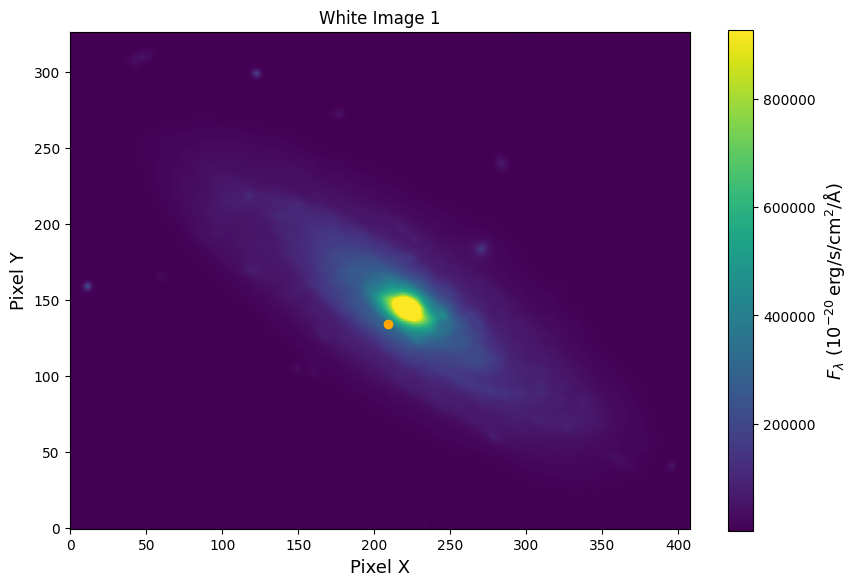

In [30]:
factor1 = 0.0001
factor2 = 10
plt.figure("White Image 1", figsize=(10, 10))

plt.scatter(centerX_ori, centerY_ori, color='orange')
plt.imshow(
    white_img,
    vmin=np.nanmedian(white_img) - factor1 * np.nanstd(white_img), 
    vmax=np.nanmedian(white_img) + factor2 * np.nanstd(white_img), 
    origin="lower"
)

plt.title("White Image 1") 
plt.ylabel("Pixel Y", fontsize=13)
plt.xlabel("Pixel X", fontsize=13)

cbar = plt.colorbar(label=r"$F_{\lambda}$ ($10^{-20} \, \text{erg/s/cm}^2/\text{Å}$)", shrink=0.65)
cbar.set_label(r"$F_{\lambda}$ ($10^{-20} \, \text{erg/s/cm}^2/\text{Å}$)", fontsize=13)

plt.show()

We search for the galaxy's center to determine its exact location and properly center the image. To achieve this, we perform a Gaussian fitting using DAOStarFinder.

In [31]:
factor = 5
daofind = DAOStarFinder(
   fwhm=6.0,
   threshold=factor * np.std(white_img)
) # It returns a table with the values of x, y.

In [32]:
# This is used to mask the center of the galaxy, so that stars are not searched in that area.
maskCenter = np.zeros(white_img.shape, dtype=bool)
edge = 150
maskCenter[edge:-edge, edge:-edge] = True
print(maskCenter.shape)

(327, 408)


In [33]:
sources = daofind(
   white_img - np.std(white_img),
   mask=maskCenter
)

In [34]:
for col in sources.colnames:
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'
sources.pprint(max_width=76)

 id xcentroid ycentroid sharpness ...     flux      mag   daofind_mag
--- --------- --------- --------- ... ------------ ------ -----------
  1    221.88    145.04      0.43 ... 115078104.00 -20.15       -2.09


In [35]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
centerX_real = positions[0][0]
centerY_real = positions[0][1]
print(f"This is the position of the galaxy's center obtained using DAOStarFinder ({centerX_real}, {centerY_real})")

This is the position of the galaxy's center obtained using DAOStarFinder (221.88091001518575, 145.03940840970756)


In [36]:
apertures = CircularAperture(positions, r=2)
out_phot = aperture_photometry(white_img, apertures)

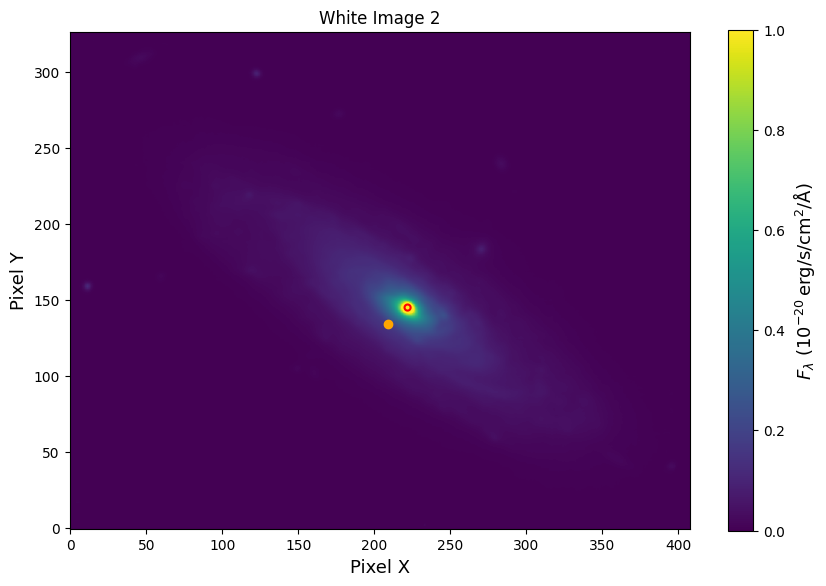

In [37]:
factor1 = 0.0001
factor2 = 20
plt.figure("White Image 2", figsize=(10, 10))

plt.imshow(
    white_img,
    vmin=np.nanmedian(white_img) - factor1 * np.nanstd(white_img), 
    vmax=np.nanmedian(white_img) + factor2 * np.nanstd(white_img), 
    origin="lower"
)

plt.scatter(centerX_ori, centerY_ori, color='orange')


apertures.plot(color='red', lw=1.5)

plt.title("White Image 2") 
plt.ylabel("Pixel Y", fontsize=13)
plt.xlabel("Pixel X", fontsize=13)

cbar = plt.colorbar(label=r"$F_{\lambda}$ ($10^{-20} \, \text{erg/s/cm}^2/\text{Å}$)", shrink=0.65)
cbar.set_label(r"$F_{\lambda}$ ($10^{-20} \, \text{erg/s/cm}^2/\text{Å}$)", fontsize=13)

plt.show()

Next, we will change the axis labels to modify the reference system. Additionally, we will convert from pixels to arcsec, taking into account the relationship they follow. We will do this using the function we defined at the beginning. Therefore, we change the axes to $\Delta X$ and $\Delta Y$ in arcsec, where $\Delta$ represents the distance to the center of the galaxy.

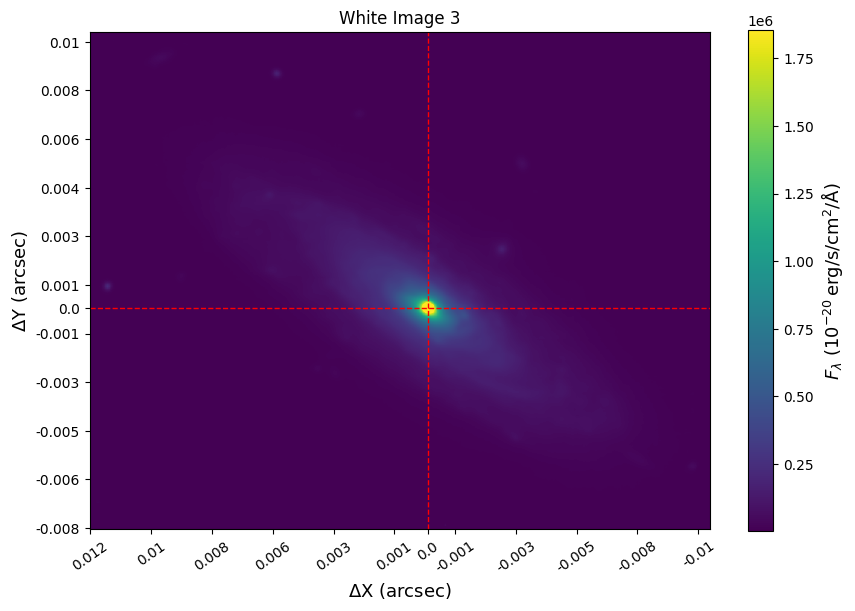

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))

centerX, centerY, x_img, y_img, xticks, yticks, ticksRAlabel, ticksDEClabel = transform_ticks(white_img, centerX_real, centerY_real)

factor1 = 0.0001
factor2 = 20

plt.imshow(
    white_img,
    vmin=np.nanmedian(white_img) - factor1 * np.nanstd(white_img), 
    vmax=np.nanmedian(white_img) + factor2 * np.nanstd(white_img), 
    origin="lower"
)

ax.set_xticks(xticks, labels=ticksRAlabel)
ax.set_yticks(yticks, labels=ticksDEClabel)

# We rotate the x-axis labels to make the part of 0 more readable.
plt.xticks(rotation=35)

# We draw the (0,0) of the new reference system.
ax.axhline(y_img, color='red', linestyle='--', linewidth=1)
ax.axvline(x_img, color='red', linestyle='--', linewidth=1)

plt.title("White Image 3") 
plt.ylabel("$\Delta$Y (arcsec)", fontsize=13)
plt.xlabel("$\Delta$X (arcsec)", fontsize=13)

cbar = plt.colorbar(label=r"$F_{\lambda}$ ($10^{-20} \, \text{erg/s/cm}^2/\text{Å}$)", shrink=0.65)
cbar.set_label(r"$F_{\lambda}$ ($10^{-20} \, \text{erg/s/cm}^2/\text{Å}$)", fontsize=13)

plt.show()

# 7.- R-band image and I-band image

In this section, we will obtain an image in the R-band and I-band in magnitudes. These will be represented using the same axes as in the previous section, i.e., $\Delta$X and $\Delta$Y in arcseconds. The R-band corresponds to the wavelength range between 5500 Å and 7000 Å, while the I-band corresponds to the range between 7000 Å and 8500 Å.

Therefore, we need to follow a process similar to the one used to obtain the "white" image, but considering the wavelength range we are working with. Additionally, since we need to work in magnitudes, we must apply a conversion.

In [119]:
lambdasArray = np.array(lambdasA)
lambdaR = lambdasArray[(lambdasArray >= 5500) & (lambdasArray <= 7000)]
lambdaI = lambdasArray[(lambdasArray >= 7000) & (lambdasArray <= 8500)]

In [120]:
print(f"Wavelength range for the R-band: ", lambdaR)
print(f"Wavelength range for the I-band: ", lambdaI)

Wavelength range for the R-band:  [5501.06054688 5502.31054688 5503.56054688 ... 6997.31054688 6998.56054688
 6999.81054688]
Wavelength range for the I-band:  [7001.06054688 7002.31054688 7003.56054688 ... 8497.31054688 8498.56054688
 8499.81054688]


Now we need to obtain the indices of these values in 'data' to extract only the values within that range.

In [121]:
first_indexR = int(np.where(lambdasArray == lambdaR[0])[0][0])
last_indexR = int(np.where(lambdasArray == lambdaR[-1])[0][0])
print(f"These are the indices corresponding to the extremes of the R-band in the data cube: ({first_indexR}, {last_indexR})")

These are the indices corresponding to the extremes of the R-band in the data cube: (602, 1801)


In [122]:
first_indexI= int(np.where(lambdasArray == lambdaI[0])[0][0])
last_indexI = int(np.where(lambdasArray == lambdaI[-1])[0][0])
print(f"These are the indices corresponding to the extremes of the I-band in the data cube: ({first_indexI}, {last_indexI})")

These are the indices corresponding to the extremes of the I-band in the data cube: (1802, 3001)


I extract the data to perform the same process as with white_image, but within the appropriate wavelength range for each band

In [123]:
dataR = data[first_indexR:last_indexR, :, :]
dataR.shape

(1199, 327, 408)

In [124]:
dataI = data[first_indexI:last_indexI, :, :]
dataI.shape

(1199, 327, 408)

We need to convert to magnitudes using the formula: 𝑚 = − 2.5 log(flux) − 21.1. To do this, we must ensure that flux is the integrated flux. We recover the correct units (erg $s^{-1}$ $cm^{-2}$ Å$^{-1}$)  by dividing by the wavelength range in Angstroms, also considering the $10^{-20}$ factor present in the header.

In [125]:
rangR = 7000 - 5500
rangI = 8500 - 7000

In [126]:
image_bandR = np.nansum(dataR, axis=0) 

In [127]:
flux_bandR = (image_bandR / rangR) * (10 ** (-20))

In [128]:
mag_bandaR = - 2.5 * np.log10(flux_bandR) - 21.1

C:\Users\Juan Jiménez Luque\AppData\Local\Temp\ipykernel_2468\1693593334.py:1: RuntimeWarning: divide by zero encountered in log10
  mag_bandaR = - 2.5 * np.log10(flux_bandR) - 21.1
C:\Users\Juan Jiménez Luque\AppData\Local\Temp\ipykernel_2468\1693593334.py:1: RuntimeWarning: invalid value encountered in log10
  mag_bandaR = - 2.5 * np.log10(flux_bandR) - 21.1


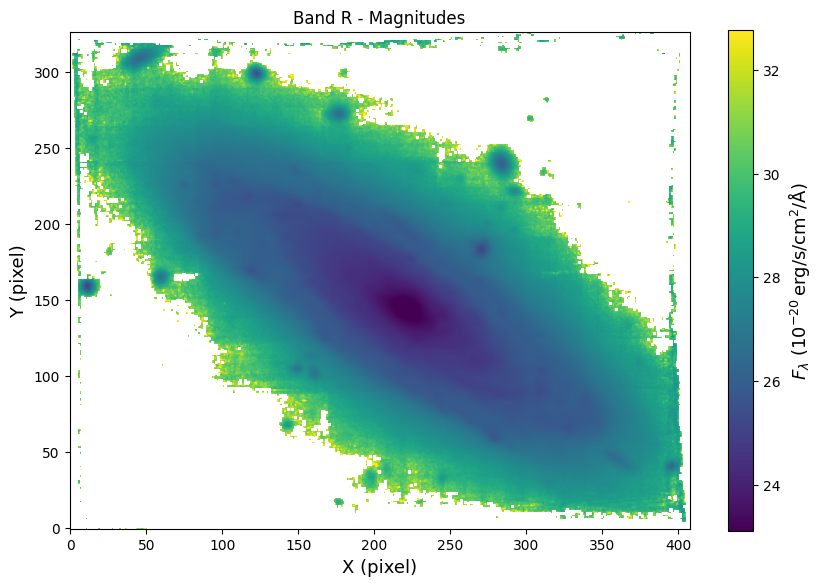

In [130]:
factor1 = 2
factor2 = 3
plt.figure("Band R - Magnitudes", figsize=(10, 10))

plt.imshow(
    mag_bandaR,
    vmin=np.nanmedian(mag_bandaR[50:-50, 50:-50]) - factor1 * np.nanstd(mag_bandaR[50:-50, 50:-50]), 
    vmax=np.nanmedian(mag_bandaR[50:-50, 50:-50]) + factor2 * np.nanstd(mag_bandaR[50:-50, 50:-50]), 
    origin="lower"
)

plt.title("Band R - Magnitudes")
plt.xlabel("X (pixel)", fontsize=13)
plt.ylabel("Y (pixel)", fontsize=13)

cbar = plt.colorbar(label=r"$F_{\lambda}$ ($10^{-20} \, \text{erg/s/cm}^2/\text{Å}$)", shrink=0.65)
cbar.set_label(r"$F_{\lambda}$ ($10^{-20} \, \text{erg/s/cm}^2/\text{Å}$)", fontsize=13)

plt.show()

Now we represent with the axes: $\Delta$X (arcsec) and $\Delta$Y (arcsec).

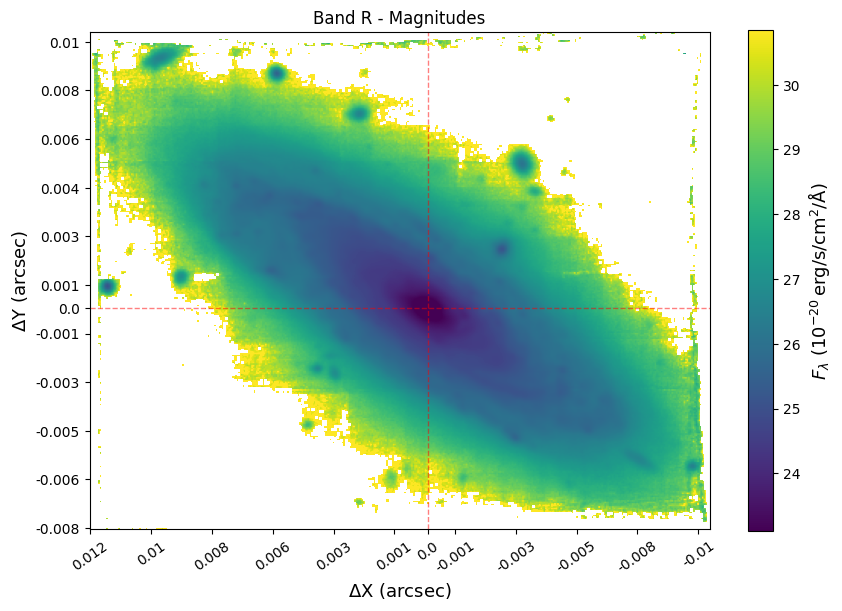

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))

centerX, centerY, x_img, y_img, xticks, yticks, ticksRAlabel, ticksDEClabel = transform_ticks(white_img, centerX_real, centerY_real)

factor1 = 2
factor2 = 2

plt.imshow(
    mag_bandaR,
    vmin=np.nanmedian(mag_bandaR[50:-50, 50:-50]) - factor1 * np.nanstd(mag_bandaR[50:-50, 50:-50]), 
    vmax=np.nanmedian(mag_bandaR[50:-50, 50:-50]) + factor2 * np.nanstd(mag_bandaR[50:-50, 50:-50]), 
    origin="lower"
)

ax.set_xticks(xticks, labels=ticksRAlabel)
ax.set_yticks(yticks, labels=ticksDEClabel)

# We rotate the x-axis labels to make the part of 0 more readable.
plt.xticks(rotation=35)

# We draw the (0,0) of the new reference system.
ax.axhline(y_img, color='red', linestyle='--', linewidth=1, alpha=0.5) 
ax.axvline(x_img, color='red', linestyle='--', linewidth=1, alpha=0.5) 

plt.title("Band R - Magnitudes") 
plt.ylabel("$\Delta$Y (arcsec)", fontsize=13)
plt.xlabel("$\Delta$X (arcsec)", fontsize=13)

cbar = plt.colorbar(label=r"$F_{\lambda}$ ($10^{-20} \, \text{erg/s/cm}^2/\text{Å}$)", shrink=0.65)
cbar.set_label(r"$F_{\lambda}$ ($10^{-20} \, \text{erg/s/cm}^2/\text{Å}$)", fontsize=13)

plt.show()

In [131]:
image_bandI = np.nansum(dataI, axis=0)

In [132]:
flux_bandI = (image_bandI / rangI) * (10 ** (-20))

In [133]:
mag_bandaI = -2.5 * np.log10(flux_bandI) - 21.1

C:\Users\Juan Jiménez Luque\AppData\Local\Temp\ipykernel_2468\1365638817.py:1: RuntimeWarning: divide by zero encountered in log10
  mag_bandaI = -2.5 * np.log10(flux_bandI) - 21.1
C:\Users\Juan Jiménez Luque\AppData\Local\Temp\ipykernel_2468\1365638817.py:1: RuntimeWarning: invalid value encountered in log10
  mag_bandaI = -2.5 * np.log10(flux_bandI) - 21.1


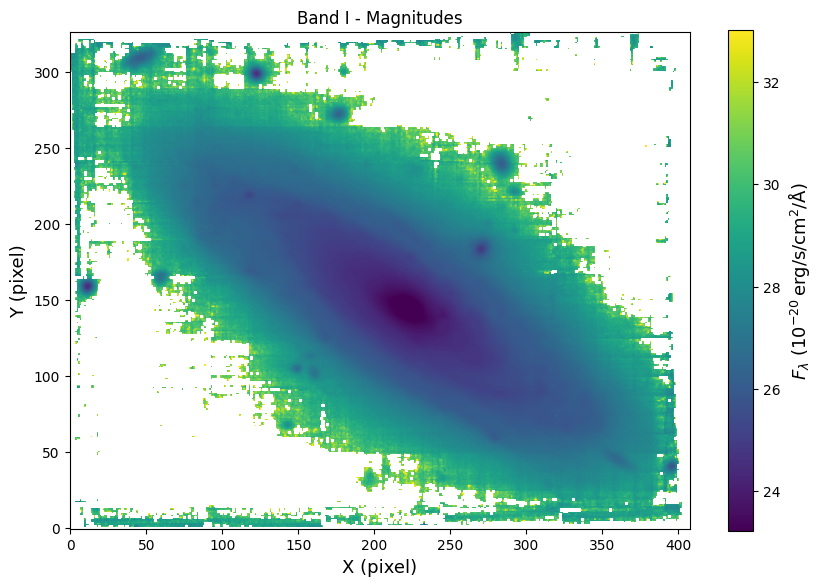

In [134]:
factor1 = 2
factor2 = 3
plt.figure("Band I - Magnitudes", figsize=(10, 10))

plt.imshow(
    mag_bandaI,
    vmin=np.nanmedian(mag_bandaI[50:-50, 50:-50]) - factor1 * np.nanstd(mag_bandaI[50:-50, 50:-50]), 
    vmax=np.nanmedian(mag_bandaI[50:-50, 50:-50]) + factor2 * np.nanstd(mag_bandaI[50:-50, 50:-50]), 
    origin="lower"
)

plt.title("Band I - Magnitudes")
plt.xlabel("X (pixel)", fontsize=13)
plt.ylabel("Y (pixel)", fontsize=13)

cbar = plt.colorbar(label=r"$F_{\lambda}$ ($10^{-20} \, \text{erg/s/cm}^2/\text{Å}$)", shrink=0.65)
cbar.set_label(r"$F_{\lambda}$ ($10^{-20} \, \text{erg/s/cm}^2/\text{Å}$)", fontsize=13)

plt.show()

Now we represent with the axes: $\Delta$X (arcsec) and $\Delta$Y (arcsec).

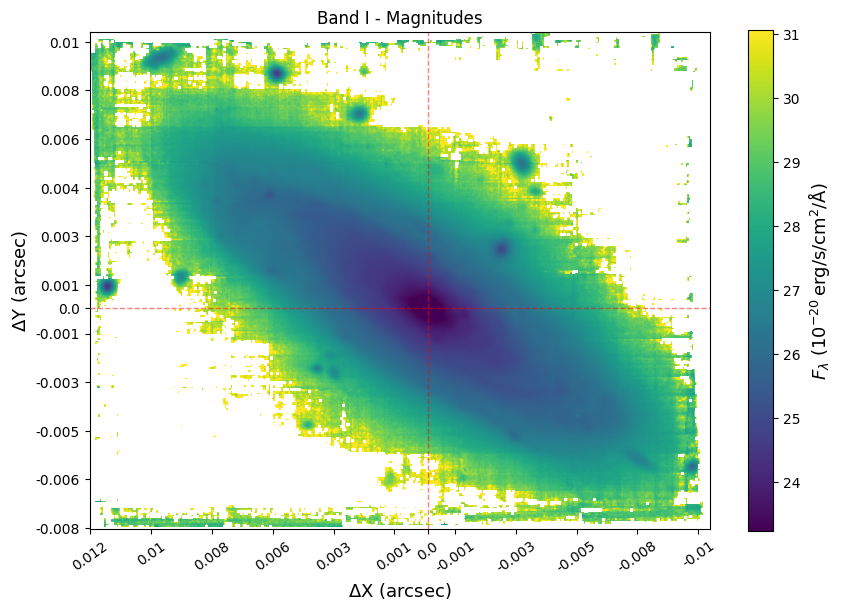

In [135]:
fig, ax = plt.subplots(figsize=(10, 10))

centerX, centerY, x_img, y_img, xticks, yticks, ticksRAlabel, ticksDEClabel = transform_ticks(white_img, centerX_real, centerY_real)

factor1 = 2
factor2 = 2

plt.imshow(
    mag_bandaI,
    vmin=np.nanmedian(mag_bandaI[50:-50, 50:-50]) - factor1 * np.nanstd(mag_bandaI[50:-50, 50:-50]), 
    vmax=np.nanmedian(mag_bandaI[50:-50, 50:-50]) + factor2 * np.nanstd(mag_bandaI[50:-50, 50:-50]), 
    origin="lower"
)

ax.set_xticks(xticks, labels=ticksRAlabel)
ax.set_yticks(yticks, labels=ticksDEClabel)

# We rotate the x-axis labels to make the part of 0 more readable.
plt.xticks(rotation=35)

# We draw the (0,0) of the new reference system.
ax.axhline(y_img, color='red', linestyle='--', linewidth=1, alpha=0.5) 
ax.axvline(x_img, color='red', linestyle='--', linewidth=1, alpha=0.5) 

plt.title("Band I - Magnitudes") 
plt.ylabel("$\Delta$Y (arcsec)", fontsize=13)
plt.xlabel("$\Delta$X (arcsec)", fontsize=13)

cbar = plt.colorbar(label=r"$F_{\lambda}$ ($10^{-20} \, \text{erg/s/cm}^2/\text{Å}$)", shrink=0.65)
cbar.set_label(r"$F_{\lambda}$ ($10^{-20} \, \text{erg/s/cm}^2/\text{Å}$)", fontsize=13)

plt.show()

# 8.- R - I color image of the galaxy


In [44]:
color_ri = mag_bandaR - mag_bandaI

C:\Users\Juan Jiménez Luque\AppData\Local\Temp\ipykernel_25152\181735608.py:1: RuntimeWarning: invalid value encountered in subtract
  color_ri = mag_bandaR - mag_bandaI


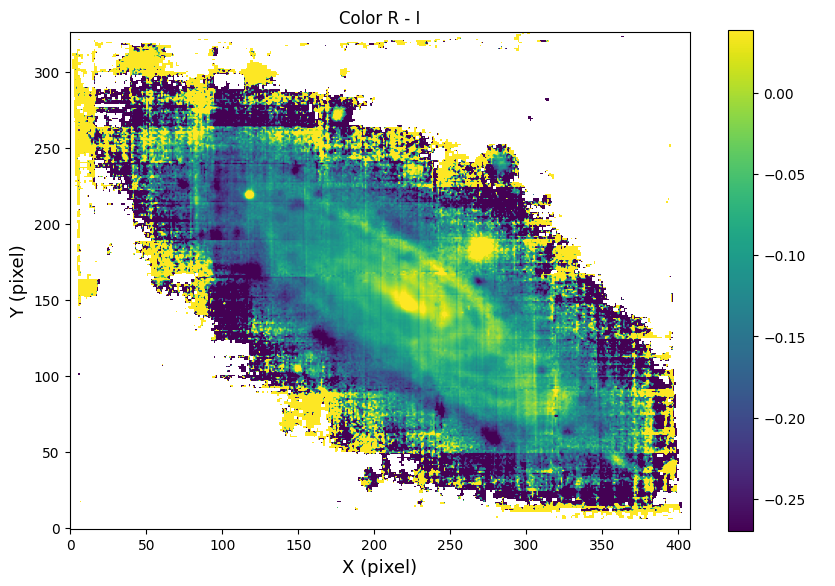

In [45]:
factor1 = 0.35
factor2 = 0.35
plt.figure("Color R - I", figsize=(10, 10))

plt.imshow(
    color_ri,
    vmin=np.nanmedian(color_ri[50:-50, 50:-50]) - factor1 * np.nanstd(color_ri[50:-50, 50:-50]), 
    vmax=np.nanmedian(color_ri[50:-50, 50:-50]) + factor2 * np.nanstd(color_ri[50:-50, 50:-50]), 
    origin="lower"
)

plt.title("Color R - I")
plt.xlabel("X (pixel)", fontsize=13)
plt.ylabel("Y (pixel)", fontsize=13)

plt.colorbar(label=" ", shrink=0.65)
plt.show()

We have represented the r-i color image, that is, we are working with the red band and the one associated with the infrared. Therefore, the most positive values we obtain will be those associated with regions where we find more dust. This dust emits because it is heated by the young and hot stars in the area. Thus, the dust zones correspond to areas with star formation, which are shown as yellow areas in the image. On the other hand, this image also provides information about the rotation direction of the galaxy, which, as can be seen, follows a dextrorotatory direction.

# 9.- $H\alpha$ image of the galaxy (decontaminated from the adjacent continuum)

We search for the galaxy's redshift in the NED catalog and obtain a value of $z$ = 0.029. Given the redshift, we can correct the wavelengths using the expression: $\lambda_{obs} = \lambda  (1 + z)$ where $\lambda_{obs}$ is the observed wavelength and $\lambda$ is the theorical wavelength.

In [39]:
z = 0.029
lambdaHa = 6563
lambdaHa_obs = lambdaHa * (1 + z)

lambdasA = np.array(lambdasA)
lambdas_obs = lambdasA * (1 + z)

To remove the continuum, we will work with wavelength windows. We will consider 3 windows, each with a width of 100 Å. One of the windows will contain the Hα line at its center, with limits of ±50 Å around this value. The other two windows will extend from the edges of the window containing Hα, maintaining the same width of 100 Å.

Next, we obtain the limits of the different wavelength windows.

In [40]:
edges_window_left = [lambdaHa_obs - 150, lambdaHa_obs - 50]
edges_window_Ha = [lambdaHa_obs - 50, lambdaHa_obs + 50]
edges_window_right = [lambdaHa_obs + 50, lambdaHa_obs + 150]

In [41]:
print(edges_window_left)
print(edges_window_Ha)
print(edges_window_right)

[6603.326999999999, 6703.326999999999]
[6703.326999999999, 6803.326999999999]
[6803.326999999999, 6903.326999999999]


We located the obtained windows, but in terms of cube indices, not wavelengths in Angstroms. To do this, we used the relationship to convert from Angstroms to cube indices.

In [42]:
firstindex_window_left = int((edges_window_left[0] - crval3) / cd33 + crpix3)
secondindex_window_left = int((edges_window_left[1] - crval3) / cd33 + crpix3)

firstindex_window_Ha = int((edges_window_Ha[0] - crval3) / cd33 + crpix3)
secondindex_window_Ha = int((edges_window_Ha[1] - crval3) / cd33 + crpix3)

firstindex_window_right = int((edges_window_right[0] - crval3) / cd33 + crpix3)
secondindex_window_right = int((edges_window_right[1] - crval3) / cd33 + crpix3)

print(firstindex_window_left, secondindex_window_left)
print(firstindex_window_Ha, secondindex_window_Ha)
print(firstindex_window_right, secondindex_window_right)

1483 1563
1563 1643
1643 1723


In [43]:
data_window_left = data[firstindex_window_left:secondindex_window_left, :, :]
data_windowHa = data[firstindex_window_Ha:secondindex_window_Ha, :, :]
data_window_right = data[firstindex_window_right:secondindex_window_right, :, :]

In [44]:
flux_window_left = np.nansum(data_window_left, axis=0)
flux_windowHa = np.nansum(data_windowHa, axis=0)
flux_window_right = np.nansum(data_window_right, axis=0)

In [45]:
window_correc = (flux_window_right + flux_window_left) / 2

In [46]:
diff_Ha_window = flux_windowHa - window_correc

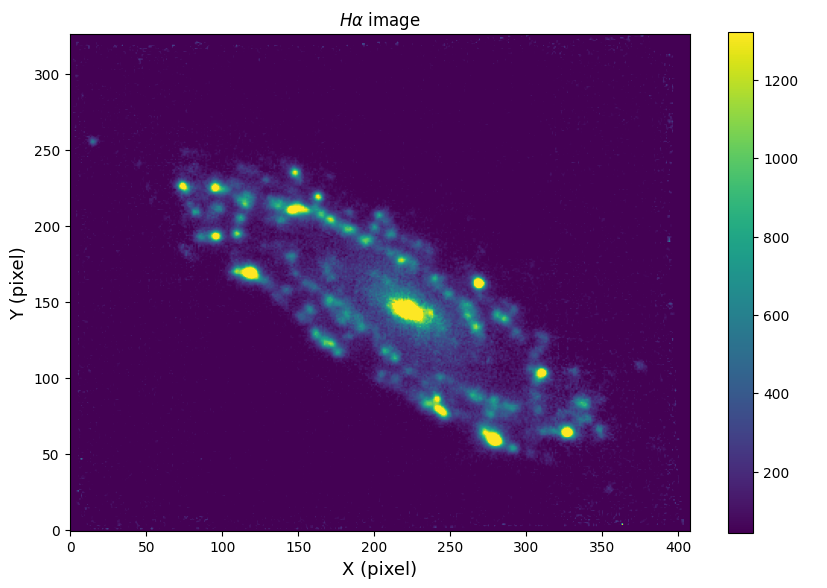

In [47]:
factor1 = 0.01
factor2 = 5
plt.figure("Imagen Ha", figsize=(10, 10))

plt.imshow(
    diff_Ha_window,
    vmin=np.nanmedian(diff_Ha_window[50:-50, 50:-50]) + 
    factor1 * np.nanstd(diff_Ha_window[50:-50, 50:-50]), 
    vmax=np.nanmedian(diff_Ha_window[50:-50, 50:-50]) + 
    factor2 * np.nanstd(diff_Ha_window[50:-50, 50:-50]), 
    origin="lower"
)

plt.title(r"$H\alpha$ image")
plt.xlabel("X (pixel)", fontsize=13)
plt.ylabel("Y (pixel)", fontsize=13)

plt.colorbar(label=" ", shrink=0.65)
plt.show()

Now we represent with the axes: $\Delta$X (arcsec) and $\Delta$Y (arcsec).

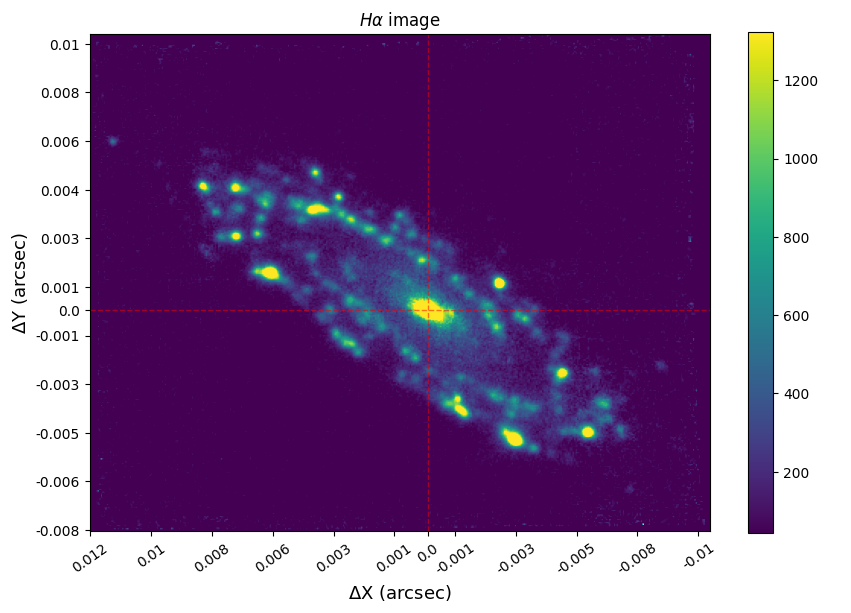

In [48]:
fig, ax = plt.subplots(figsize=(10, 10))

centerX, centerY, x_img, y_img, xticks, yticks, ticksRAlabel, ticksDEClabel = transform_ticks(diff_Ha_window, centerX_real, centerY_real)

factor1 = 0.01
factor2 = 5

plt.imshow(
    diff_Ha_window,
    vmin=np.nanmedian(diff_Ha_window[50:-50, 50:-50]) + 
    factor1 * np.nanstd(diff_Ha_window[50:-50, 50:-50]), 
    vmax=np.nanmedian(diff_Ha_window[50:-50, 50:-50]) + 
    factor2 * np.nanstd(diff_Ha_window[50:-50, 50:-50]), 
    origin="lower"
)

ax.set_xticks(xticks, labels=ticksRAlabel)
ax.set_yticks(yticks, labels=ticksDEClabel)

# We rotate the x-axis labels to make the part of 0 more readable.
plt.xticks(rotation=35)

# We draw the (0,0) of the new reference system.
ax.axhline(y_img, color='red', linestyle='--', linewidth=1, alpha=0.5) 
ax.axvline(x_img, color='red', linestyle='--', linewidth=1, alpha=0.5) 

plt.title(r"$H\alpha$ image")
plt.ylabel("$\Delta$Y (arcsec)", fontsize=13)
plt.xlabel("$\Delta$X (arcsec)", fontsize=13)

cbar = plt.colorbar(label=r"$F_{\lambda}$ ($10^{-20} \, \text{erg/s/cm}^2/\text{Å}$)", shrink=0.65)
cbar.set_label(" ", fontsize=13)

plt.show()

We located the HII regions using DAOStarFinder again. For convenience, we will work with the image in pixels to identify the lines, rather than in arcseconds.

In [49]:
factor = 6
daofindHII = DAOStarFinder(
   fwhm=5.0,
   threshold=factor * np.std(diff_Ha_window)
) # It returns a table with the values of x, y.

In [50]:
# This is used to mask the center of the galaxy, so that stars are not searched in that area.
maskCenter = np.ones(diff_Ha_window.shape, dtype=bool)
edge = 50
maskCenter[edge:-edge, edge:-edge] = False
print(maskCenter.shape)

(327, 408)


In [51]:
sourcesHII = daofindHII(
   diff_Ha_window - np.std(diff_Ha_window),
   mask=maskCenter
)

In [98]:
for col in sources.colnames:
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'
sourcesHII.pprint(max_width=76)

 id     xcentroid      ...     mag          daofind_mag     
--- ------------------ ... ----------- ---------------------
  1 278.64569670738786 ...    -12.5802    -1.264334607183488
  2  326.8509625318692 ...  -12.059821   -0.9841296090975739
  3 240.90721325981167 ...  -11.367126  -0.13061541204447336
  4    309.94854999103 ...  -11.818895   -0.7597128588333744
  5 221.88845730775637 ...  -13.088002   -1.4411374777858823
  6 268.49092585372233 ...  -12.119188   -1.2640782394027341
  7 118.31778626831304 ... -12.4029045   -0.9552138940789443
  8  95.52967349772565 ...  -11.515577   -0.5171835022949912
  9 109.49382825970721 ...  -10.797922 -0.006019942970421156
 10   146.079183725344 ...  -11.951794   -0.6501686213467261
 11  162.7670789556952 ...  -10.992299   -0.3717034654120904
 12  95.26440698094349 ...  -11.617466   -0.5361990121369804
 13   73.8524102072224 ...  -11.426086   -0.4997817574006855
 14 147.60483209137917 ...  -11.019497  -0.18651722608487173


In [53]:
positionsHII = np.transpose((sourcesHII['xcentroid'], sourcesHII['ycentroid']))
apertures = CircularAperture(positionsHII, r=2)
out_phot = aperture_photometry(diff_Ha_window, apertures)

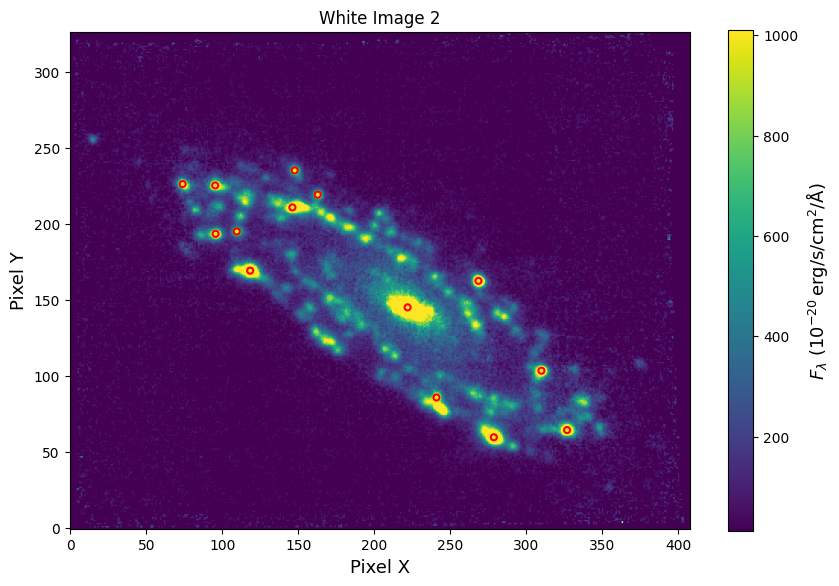

In [54]:
factor1 = 0.01
factor2 = 5

plt.figure("White Image 2", figsize=(10, 10))

plt.imshow(
    diff_Ha_window,
    vmin=np.nanmedian(diff_Ha_window) - factor1 * np.nanstd(diff_Ha_window), 
    vmax=np.nanmedian(diff_Ha_window) + factor2 * np.nanstd(diff_Ha_window), 
    origin="lower"
)


apertures.plot(color='red', lw=1.5)

plt.title("White Image 2") 
plt.ylabel("Pixel Y", fontsize=13)
plt.xlabel("Pixel X", fontsize=13)

cbar = plt.colorbar(label=r"$F_{\lambda}$ ($10^{-20} \, \text{erg/s/cm}^2/\text{Å}$)", shrink=0.65)
cbar.set_label(r"$F_{\lambda}$ ($10^{-20} \, \text{erg/s/cm}^2/\text{Å}$)", fontsize=13)

plt.show()

We identified a few ionized gas regions of interest for further study, based on the positions shown below.

In [55]:
print(positionsHII)

[[278.64569671  59.69416463]
 [326.85096253  64.4332397 ]
 [240.90721326  85.89219389]
 [309.94854999 103.48991905]
 [221.88845731 145.17140748]
 [268.49092585 162.62021336]
 [118.31778627 169.3137474 ]
 [ 95.5296735  193.55125774]
 [109.49382826 195.14183337]
 [146.07918373 210.95010619]
 [162.76707896 219.30282186]
 [ 95.26440698 225.39246907]
 [ 73.85241021 226.30947758]
 [147.60483209 235.28501898]]


We work, for example, with the one corresponding to the point (118.31778627, 169.3137474).

In [76]:
image9_1 = data[:, round(118.31778627), round(169.3137474)]

5998.560546875 9098.560546875


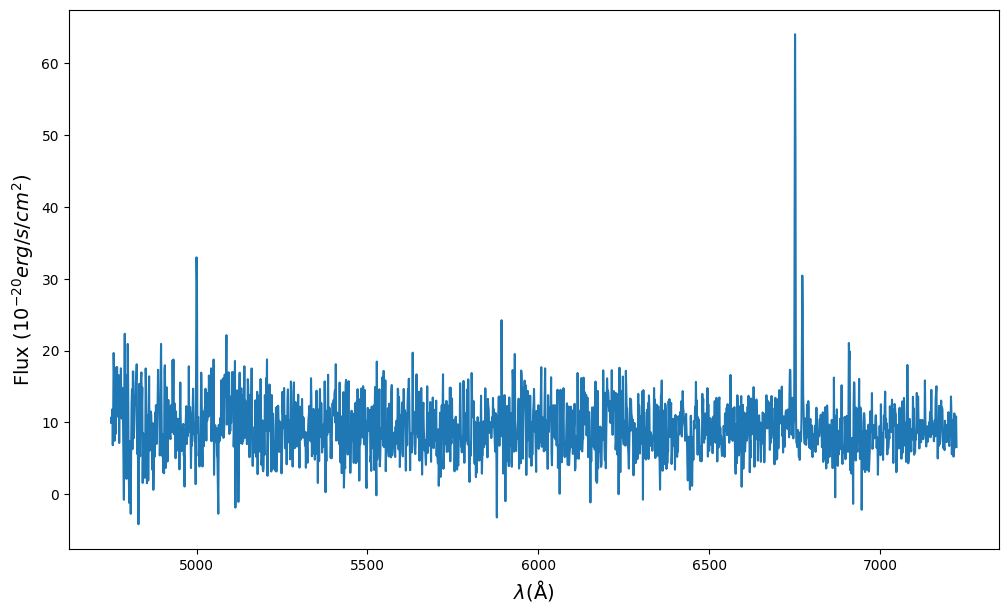

In [79]:
plt.figure("Image 9", figsize=(12, 7))

plt.plot(lambdasA[1:-1700], image9_1[1:-1700])
print(np.min(lambdasA[1000:-200]), np.max(lambdasA[1000:-200]))
plt.title(f"") 
plt.ylabel("Flux ($10^{-20}erg/s/cm^2$)", fontsize=14)
plt.xlabel("$\lambda (\mathrm{\AA})$", fontsize=14)

plt.show()

We show the spectrum that we will use as a reference to identify the lines in our spectrum.

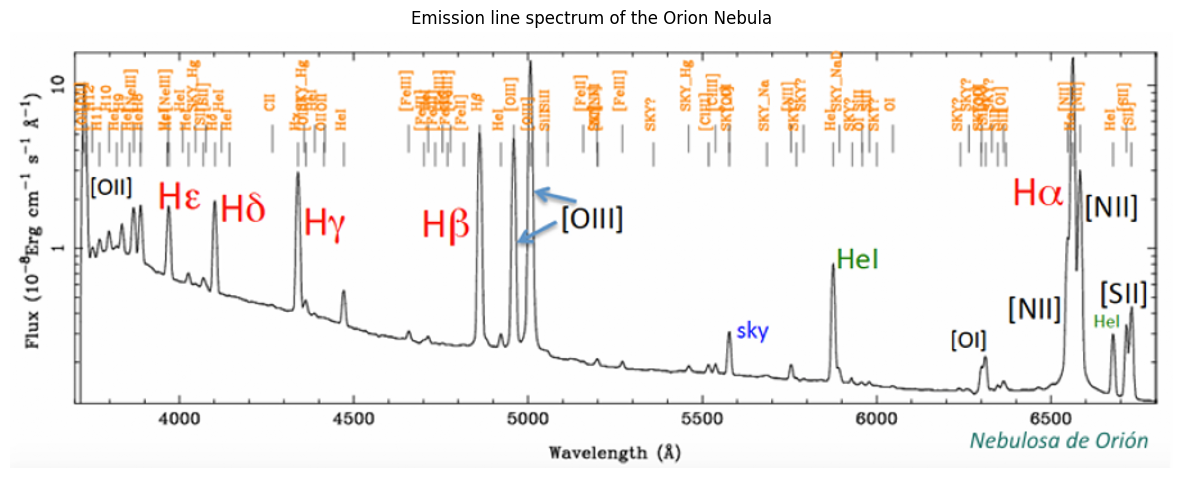

In [97]:
img = mpimg.imread('lines.png')

plt.figure(figsize=(15, 10))

plt.title('Emission line spectrum of the Orion Nebula')
plt.imshow(img)
plt.axis('off')
plt.show()

We identify the lines on our spectrum. We will mark them using vertical dashed lines, which will be shown in the legend. The numerical value used for the wavelength is approximate; the only goal is to allow a graphical representation to indicate which line corresponds to each one.

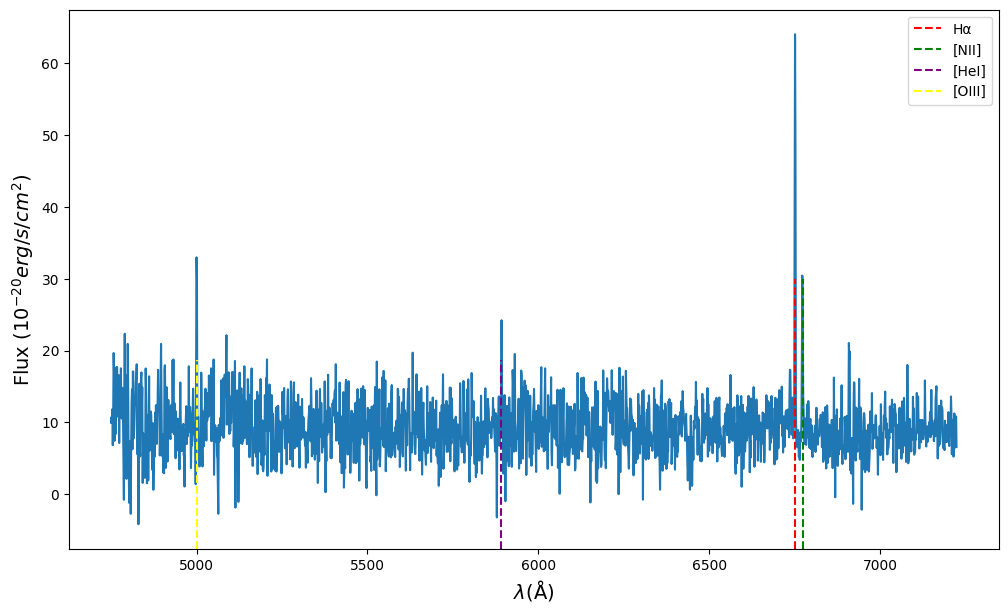

In [117]:
plt.figure("Image 9", figsize=(12, 7))

plt.plot(lambdasA[1:-1700], image9_1[1:-1700])


# We add the lines once we have identified them.
plt.axvline(x=6750, color='red', linestyle='--', label="Hα", ymin=0, ymax=0.5)
plt.axvline(x=6775, color='green', linestyle='--', label="[NII]", ymin=0, ymax=0.5)
plt.axvline(x=5890, color='purple', linestyle='--', label="[HeI]", ymin=0, ymax=0.35)
plt.axvline(x=5000, color='yellow', linestyle='--', label="[OIII]", ymin=0, ymax=0.35)



plt.title("") 
plt.ylabel("Flux ($10^{-20}erg/s/cm^2$)", fontsize=14)
plt.xlabel("$\lambda (\mathrm{\AA})$", fontsize=14)

plt.legend()
plt.show()

# 10.- Analyzing the redshift of the galaxy from the emission lines.

We identified an emission line and calculated the galaxy’s redshift from it. The emission line we will focus on is the $H\alpha$ line. The equation that allows us to calculate the redshift from the galaxy’s emission lines is the following: $$\displaystyle z = \frac{\lambda_{obs} - \lambda_{cen}}{\lambda_{cen}}$$ where $\lambda_{obs}$ is the observed wavelength, i.e., the value we will measure from the spectrum, and $\lambda_{cen}$ is the rest-frame wavelength of the line. We begin by extracting the spectrum from the center of the galaxy.

In [77]:
image10_1 = data[:, round(centerX_real), round(centerY_real)]

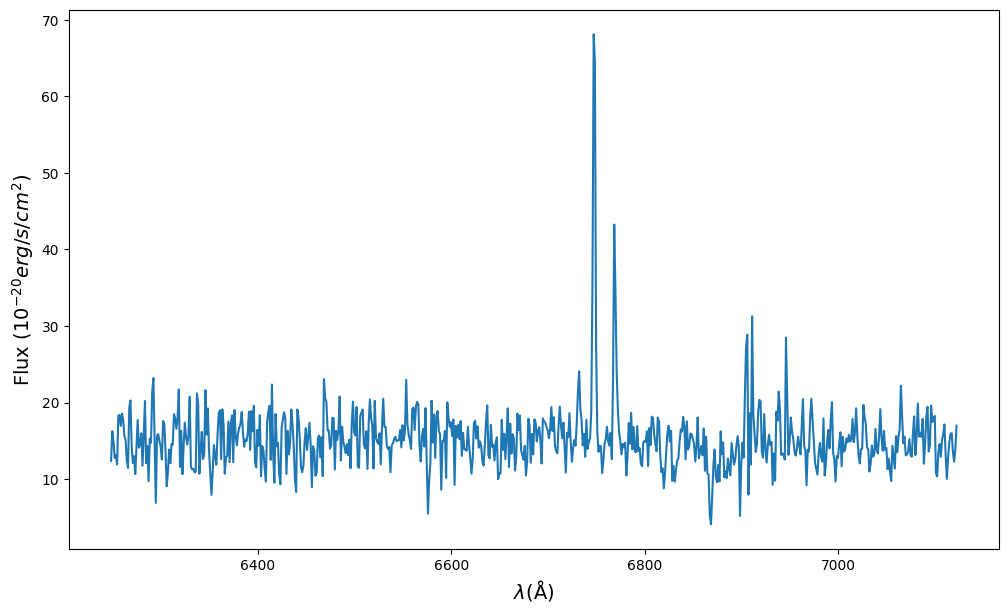

In [88]:
plt.figure("Image 10 a", figsize=(12, 7))

plt.plot(lambdasA[1200:1900], image10_1[1200:1900])


plt.title(f"") 
plt.ylabel("Flux ($10^{-20}erg/s/cm^2$)", fontsize=14)
plt.xlabel("$\lambda (\mathrm{\AA})$", fontsize=14)

plt.show()

Next, we zoom in on the image to better visualize the $H\alpha$ line. We will fit the line with a Gaussian function, and take the center value of the Gaussian as the observed wavelength of the $H\alpha$ line.

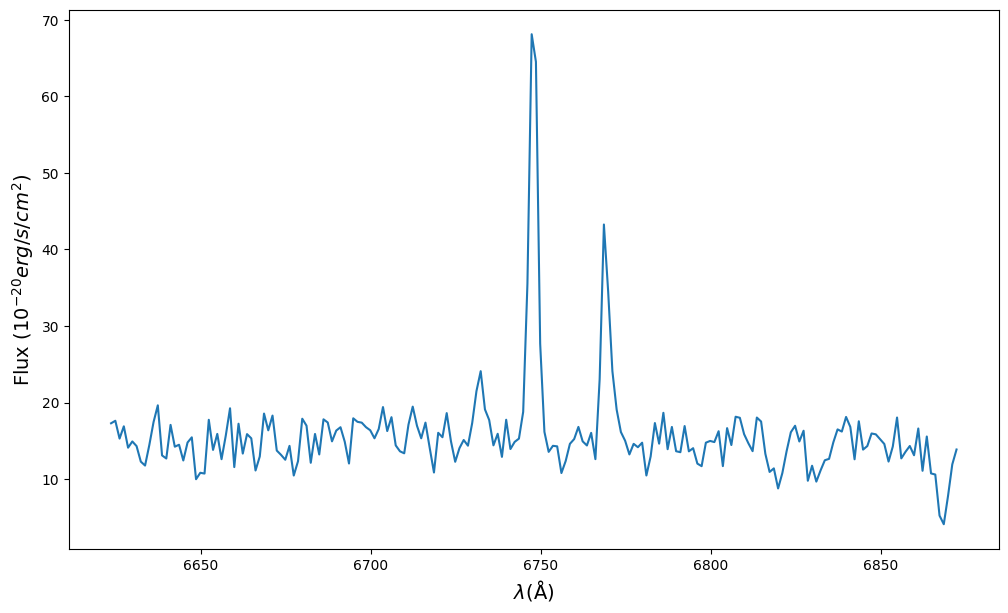

In [89]:
plt.figure("Image 10 b", figsize=(12, 7))

plt.plot(lambdasA[1500:1700], image10_1[1500:1700])


plt.title(f"") 
plt.ylabel("Flux ($10^{-20}erg/s/cm^2$)", fontsize=14)
plt.xlabel("$\lambda (\mathrm{\AA})$", fontsize=14)

plt.show()

Here, we apply a combined model—a Gaussian plus a polynomial function—in order to fit both the $H\alpha$ line and the continuum. The center of the Gaussian provides the value of $\lambda_{obs}$.

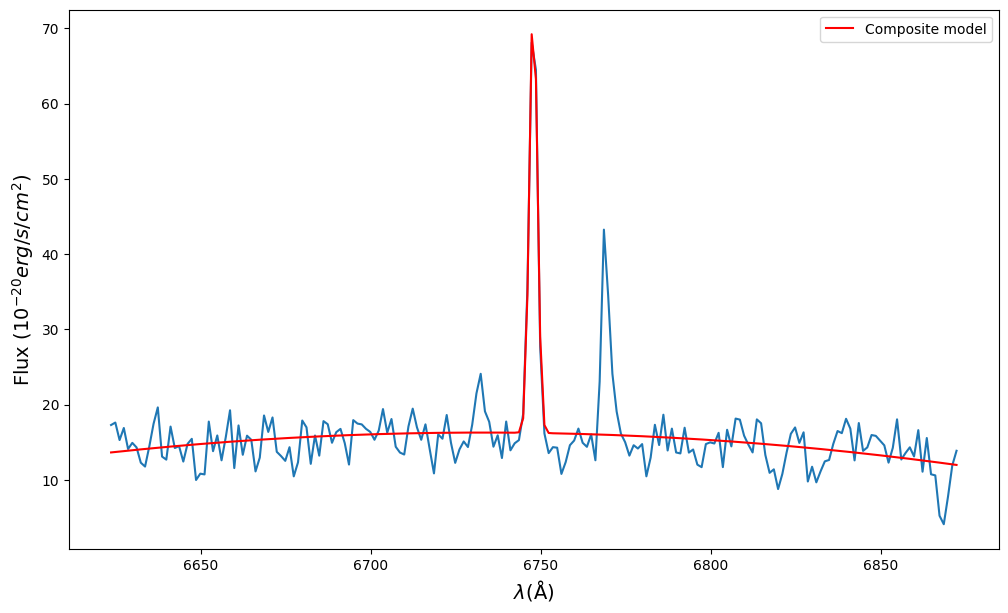

This is the value of the wavelength obtained with the defined model: 6747.809648513159 Å


In [66]:
plt.figure("Image 10 b fit", figsize=(12, 7))

x = lambdasA[1500:1700]
y = data[:, round(centerX_real), round(centerY_real)][1500:1700]

# Gaussian model
g_init = models.Gaussian1D(amplitude=np.max(y), mean=x[np.argmax(y)], stddev=1.0)

# Polynomial model
p_init = models.Polynomial1D(degree=2) 

# Composite model, Gaussian + Polynomial
model = g_init + p_init

fit = fitting.TRFLSQFitter()

# We apply the model to the data.
fitted_model = fit(model, x, y)


plt.plot(x, y)
plt.plot(x, fitted_model(x), label='Composite model', color='red')  
plt.ylabel("Flux ($10^{-20}erg/s/cm^2$)", fontsize=14)
plt.xlabel("$\lambda (\mathrm{\AA})$", fontsize=14)  
plt.legend()  
plt.show()

lambdaHa_obs1 = fitted_model.mean_0.value
print(f"This is the value of the wavelength obtained with the defined model: {fitted_model.mean_0.value} Å")

Next, we obtain the redshift of the central region of the galaxy using the expression previously shown: $\displaystyle z = \frac{\lambda_{obs} - \lambda_{cen}}{\lambda_{cen}}$.

In [67]:
z0 = (lambdaHa_obs1 - lambdaHa) / lambdaHa
print(z0)

0.028159324777260266


The redshift value according to the NED catalog is 0.029000 ± 2.13e-4, which corresponds to the interval [0.028787, 0.029213]. As we can see, the observed value does not fall within this interval; however, the error of the observed redshift has not been considered. The upper limit of this error could fall within the interval. Despite this, it is a very good estimate of the redshift, and we are satisfied with the result. Additionally, in other regions of the galaxy, as we will observe below, the redshift is higher, so it would be sensible to compare it with the average of several redshift values.

We now take a line associated with the spectrum of a point outside the galaxy’s center, that is, a point in the disk.

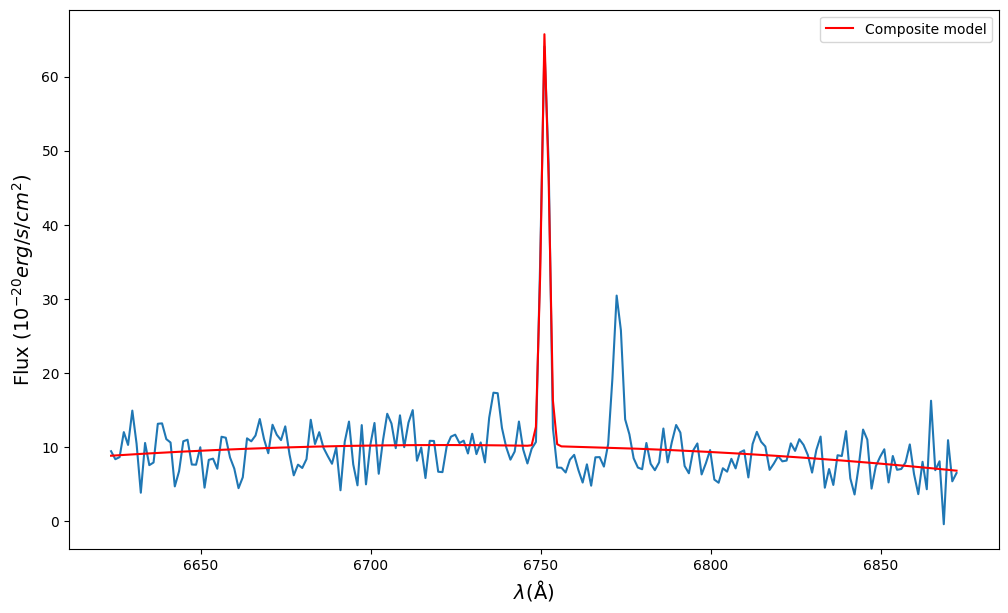

This is the value of the wavelength obtained with the defined model: 6751.268215934466 Å


In [68]:
plt.figure("Image 10 c fit", figsize=(12, 7))

x = lambdasA[1500:1700]
y = data[:, round(118.31778627), round(169.3137474)][1500:1700]

# Gaussian model
g_init = models.Gaussian1D(amplitude=np.max(y), mean=x[np.argmax(y)], stddev=1.0)

# Polynomial model
p_init = models.Polynomial1D(degree=2) 

# Composite model, Gaussian + Polynomial
model = g_init + p_init

fit = fitting.TRFLSQFitter()

# We apply the model to the data.
fitted_model = fit(model, x, y)


plt.plot(x, y)
plt.plot(x, fitted_model(x), label='Composite model', color='red')  
plt.ylabel("Flux ($10^{-20}erg/s/cm^2$)", fontsize=14)
plt.xlabel("$\lambda (\mathrm{\AA})$", fontsize=14)  
plt.legend()  
plt.show()

lambdaHa_obs2 = fitted_model.mean_0.value
print(f"This is the value of the wavelength obtained with the defined model: {fitted_model.mean_0.value} Å")

We calculate the redshift for this point in the galaxy.

In [69]:
z1 = (lambdaHa_obs2 - lambdaHa) / lambdaHa
print(z1)

0.028686304423962493


We now take a line associated with the spectrum of a point outside the galaxy’s center.

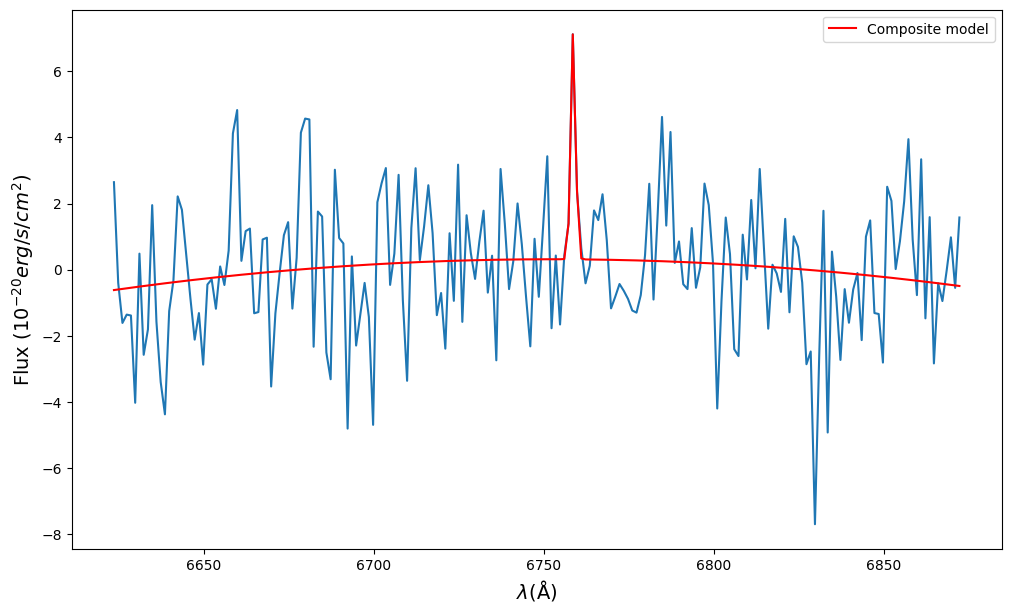

This is the value of the wavelength obtained with the defined model: 6758.6929329509985 Å


In [70]:
plt.figure("Image 10 d fit", figsize=(12, 7))

x = lambdasA[1500:1700]
y = data[:, round(268.49092585), round(162.62021336)][1500:1700]

# Gaussian model
g_init = models.Gaussian1D(amplitude=np.max(y), mean=x[np.argmax(y)], stddev=1.0)

# Polynomial model
p_init = models.Polynomial1D(degree=2) 

# Composite model, Gaussian + Polynomial
model = g_init + p_init

fit = fitting.TRFLSQFitter()

# We apply the model to the data.
fitted_model = fit(model, x, y)


plt.plot(x, y)
plt.plot(x, fitted_model(x), label='Composite model', color='red')  
plt.ylabel("Flux ($10^{-20}erg/s/cm^2$)", fontsize=14)
plt.xlabel("$\lambda (\mathrm{\AA})$", fontsize=14)  
plt.legend()  
plt.show()

lambdaHa_obs3 = fitted_model.mean_0.value
print(f"This is the value of the wavelength obtained with the defined model: {fitted_model.mean_0.value} Å")

We calculate the redshift for this point in the galaxy.

In [71]:
z2 = (lambdaHa_obs3 - lambdaHa) / lambdaHa
print(z2)

0.029817603679871782


We have obtained the redshift value at two different points in addition to the center of the galaxy. The values obtained are 0.02869 and 0.02982, which are similar to the one obtained at the center of the galaxy and that from the NED. These redshift values at different points in the galaxy's disk can help us study the galaxy's rotation.

# Conclusions

We have learned how to work with a data cube, both by extracting information from the header—such as the units or the necessary conversion factors—and by handling the cube data itself, which consists of three dimensions: two spatial and one in wavelength. We have visualized images of the galaxy at different wavelength values, as well as spectra associated with different points in the galaxy.

Next, we obtained a 'white' image (moment 0) from the data cube. This image was plotted with axes $\Delta x$ [arcsec] and $\Delta y$ [arcsec], where $\Delta$ represents the distance to the center of the galaxy. To do this, we had to locate the galaxy's center using DAOStarFinder. We also represented an r-band image, an i-band image, and an r-i color image, from which we were able to extract information about the star formation and rotation of the galaxy.

Finally, we worked with the galaxy’s spectrum, where we identified the lines of $H\alpha$, [NII], [HI], and [OIII]. Additionally, by analyzing the $H\alpha$ emission line, we were able to calculate the galaxy's redshift and compare it across different regions and with the value reported in the NED catalog.

